In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.animation as animation

# enable matplotlib display static plot within jupyter notebook
%matplotlib inline 

In [2]:
# set up plot style
from matplotlib import cycler
colors = cycler('color',
                ['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0'])
plt.rc('figure', facecolor='#222222')
plt.rc('axes', facecolor='#222222', edgecolor='#222222',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
plt.rc('grid', color='#e3e3e3', linestyle='solid')
plt.rc('xtick', direction='in', color='#e3e3e3')
plt.rc('ytick', direction='in', color='#e3e3e3')
plt.rc('patch', edgecolor='#e3e3e3')
plt.rc('lines', linewidth=1.5)

In [3]:
df_sydney=pd.read_csv('./sydney-max-tmp.csv')
df_sydney.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66062,1859,1,1,24.4,NaN,Y
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y


In [4]:
df_sydney['date'] = df_sydney['Year'].astype(str) + '-' + df_sydney['Month'].astype(str) + '-' + df_sydney['Day'].astype(str)
df_sydney['date']=[datetime.strptime(d, '%Y-%m-%d').date() for d in df_sydney['date']]
df_sydney.rename(columns={'Maximum temperature (Degree C)':'max_tmp_day'}, inplace=True)
df_sydney['max_tmp_year']=df_sydney.groupby('Year')['max_tmp_day'].transform('max')
df_sydney[['Days of accumulation of maximum temperature']]=df_sydney[['Days of accumulation of maximum temperature']].fillna(0)
df_sydney['diff']=df_sydney['max_tmp_year'] - df_sydney['max_tmp_day']
df_sydney['hot'] = np.NaN

for i in range(df_sydney.shape[0]):
    if df_sydney['diff'][i] <= (df_sydney['max_tmp_year'][i]-30): # find out days with temp. above 30 degree and assign them 1
        df_sydney['hot'][i] = 1

df_sydney['hot_day']=df_sydney.groupby('Year')['hot'].transform('sum') # calculate how many hot days
df_sydney=df_sydney.astype({'hot_day':int}) # convert from float to int, if not, y-axis will be labled using float number for day
df_sydney.head() # we can igore the warning

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Product code,Bureau of Meteorology station number,Year,Month,Day,max_tmp_day,Days of accumulation of maximum temperature,Quality,date,max_tmp_year,diff,hot,hot_day
0,IDCJAC0010,66062,1859,1,1,24.4,0.0,Y,1859-01-01,36.9,12.5,NaN,18
1,IDCJAC0010,66062,1859,1,2,24.4,1.0,Y,1859-01-02,36.9,12.5,NaN,18
2,IDCJAC0010,66062,1859,1,3,24.2,1.0,Y,1859-01-03,36.9,12.7,NaN,18
3,IDCJAC0010,66062,1859,1,4,24.7,1.0,Y,1859-01-04,36.9,12.2,NaN,18
4,IDCJAC0010,66062,1859,1,5,24.6,1.0,Y,1859-01-05,36.9,12.3,NaN,18


In [11]:
def draw_linechart(Num_Year):
    ''' 
    This is the function to make a plot
    '''
    # since many figures will be generated for animation, old axes need to be cleared before drawing new axes
    ax.clear() 
    ax2.clear()
    
    # select data till the indicated year
    df_tmp=df_sydney.loc[df_sydney['Year'] <= Num_Year] 
    
    # The frame of the whole figure, use the full data
    # excluding from the automatic legend element selection by 
    # defining a label starting with an underscore.
    ax.plot(df_sydney.Year, df_sydney.max_tmp_year*0, label='_1', color='#222222', zorder=1)
    
    # The horizontal line to indicate 40 degree, use the full data
    ax.plot(df_sydney.Year, (df_sydney.max_tmp_year**0)*40, label='_1', color='#fc280f', linestyle='dashed', alpha=0.1, linewidth=0.5, zorder=1)

    # The horizontal line to indicate 20 days, use the full data
    ax2.plot(df_sydney.Year, (df_sydney.hot_day**0)*20, label='_2', color='#eeb72b', linestyle='dashed', alpha=0.1, linewidth=0.5, zorder=1)

    # line plot
    ax.plot(df_tmp.Year, df_tmp.max_tmp_year, label='Yearly max. temp. ($^\circ$C)', 
            color='#fc280f', zorder=3)
    ax2.plot(df_tmp.Year, df_tmp.hot_day, label='Yearly accumulated days above 30$^\circ$C', 
             color='#eeb72b', zorder=3)

    # dot at the end of the line
    ax.scatter(df_tmp.Year.values[-1], df_tmp.max_tmp_year.values[-1], color='#fc280f', s=60, edgecolor ='w', linewidth=1, zorder=4)
    ax2.scatter(df_tmp.Year.values[-1], df_tmp.hot_day.values[-1], color='#eeb72b', s=60, edgecolor ='w', linewidth=1, zorder=4)

    # text associated with the dot in the figure
    ax.text(df_tmp.Year.values[-1], df_tmp.max_tmp_year.values[-1]+5,
            s='Temp. {}'.format(df_tmp.max_tmp_year.values[-1]), size=10, 
            color='#fc280f', ha='center', va='bottom', zorder=5)
    ax2.text(df_tmp.Year.values[-1], df_tmp.hot_day.values[-1]+0.7, 
             s='{} Days'.format(int(df_tmp.hot_day.values[-1])), size=10, 
             color='#eeb72b', ha='center', va='bottom', zorder=5)

    # display year in the background
    ax.text(0.5, 0.5, s=df_tmp.Year.values[-1], fontweight='bold', size=60, 
            color='#e3e3e3', ha='center', va="center", 
            alpha=0.5, transform=ax.transAxes, zorder=2)

    # legend for red line
    l1 = ax.legend(loc='upper left')
    
    for text in l1.get_texts():
        text.set_color('#e3e3e3')
    
    # legend for yellow line
    l2 = ax2.legend(loc='upper right')
    
    for text in l2.get_texts():
        text.set_color('#e3e3e3')
    
    # set the y-axis to have enough space for other elements, such as legends
    ax.set_ylim(0, df_sydney.max_tmp_year.max()*1.68)
    # do not show the grid in the background
    ax.grid(b=None)
    ax.set_ylabel('Temperature ($^\circ$C)', color='#e3e3e3')
    
    ax2.grid(b=None) # Don't show grid of ax2 
    ax2.set_ylim(df_tmp.hot_day.min()-5, df_tmp.hot_day.max()*1.5)
    ax2.set_ylabel('Day', color='#e3e3e3')
    
    # set color for axes frame
    ax2.spines['bottom'].set_color('#e3e3e3')  
    ax2.spines['right'].set_color('#e3e3e3')  
    ax2.spines['left'].set_color('#e3e3e3')  
    ax2.spines['top'].set_color('#e3e3e3') 

    # Retrieve an element of a plot and set properties
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize('x-small')

    ax.margins(x=0.05)

    ax.text(0.00, 1.05, 'Sydney Annual Maximum Temperature From 1859 to 2019', color='#e3e3e3', 
             transform=ax.transAxes, size=17, weight='light', ha='left')
    ax.text(0.00, -0.1, 'Data source from http://www.bom.gov.au', color='#e3e3e3', 
             transform=ax.transAxes, size=5, weight='light', ha='left')


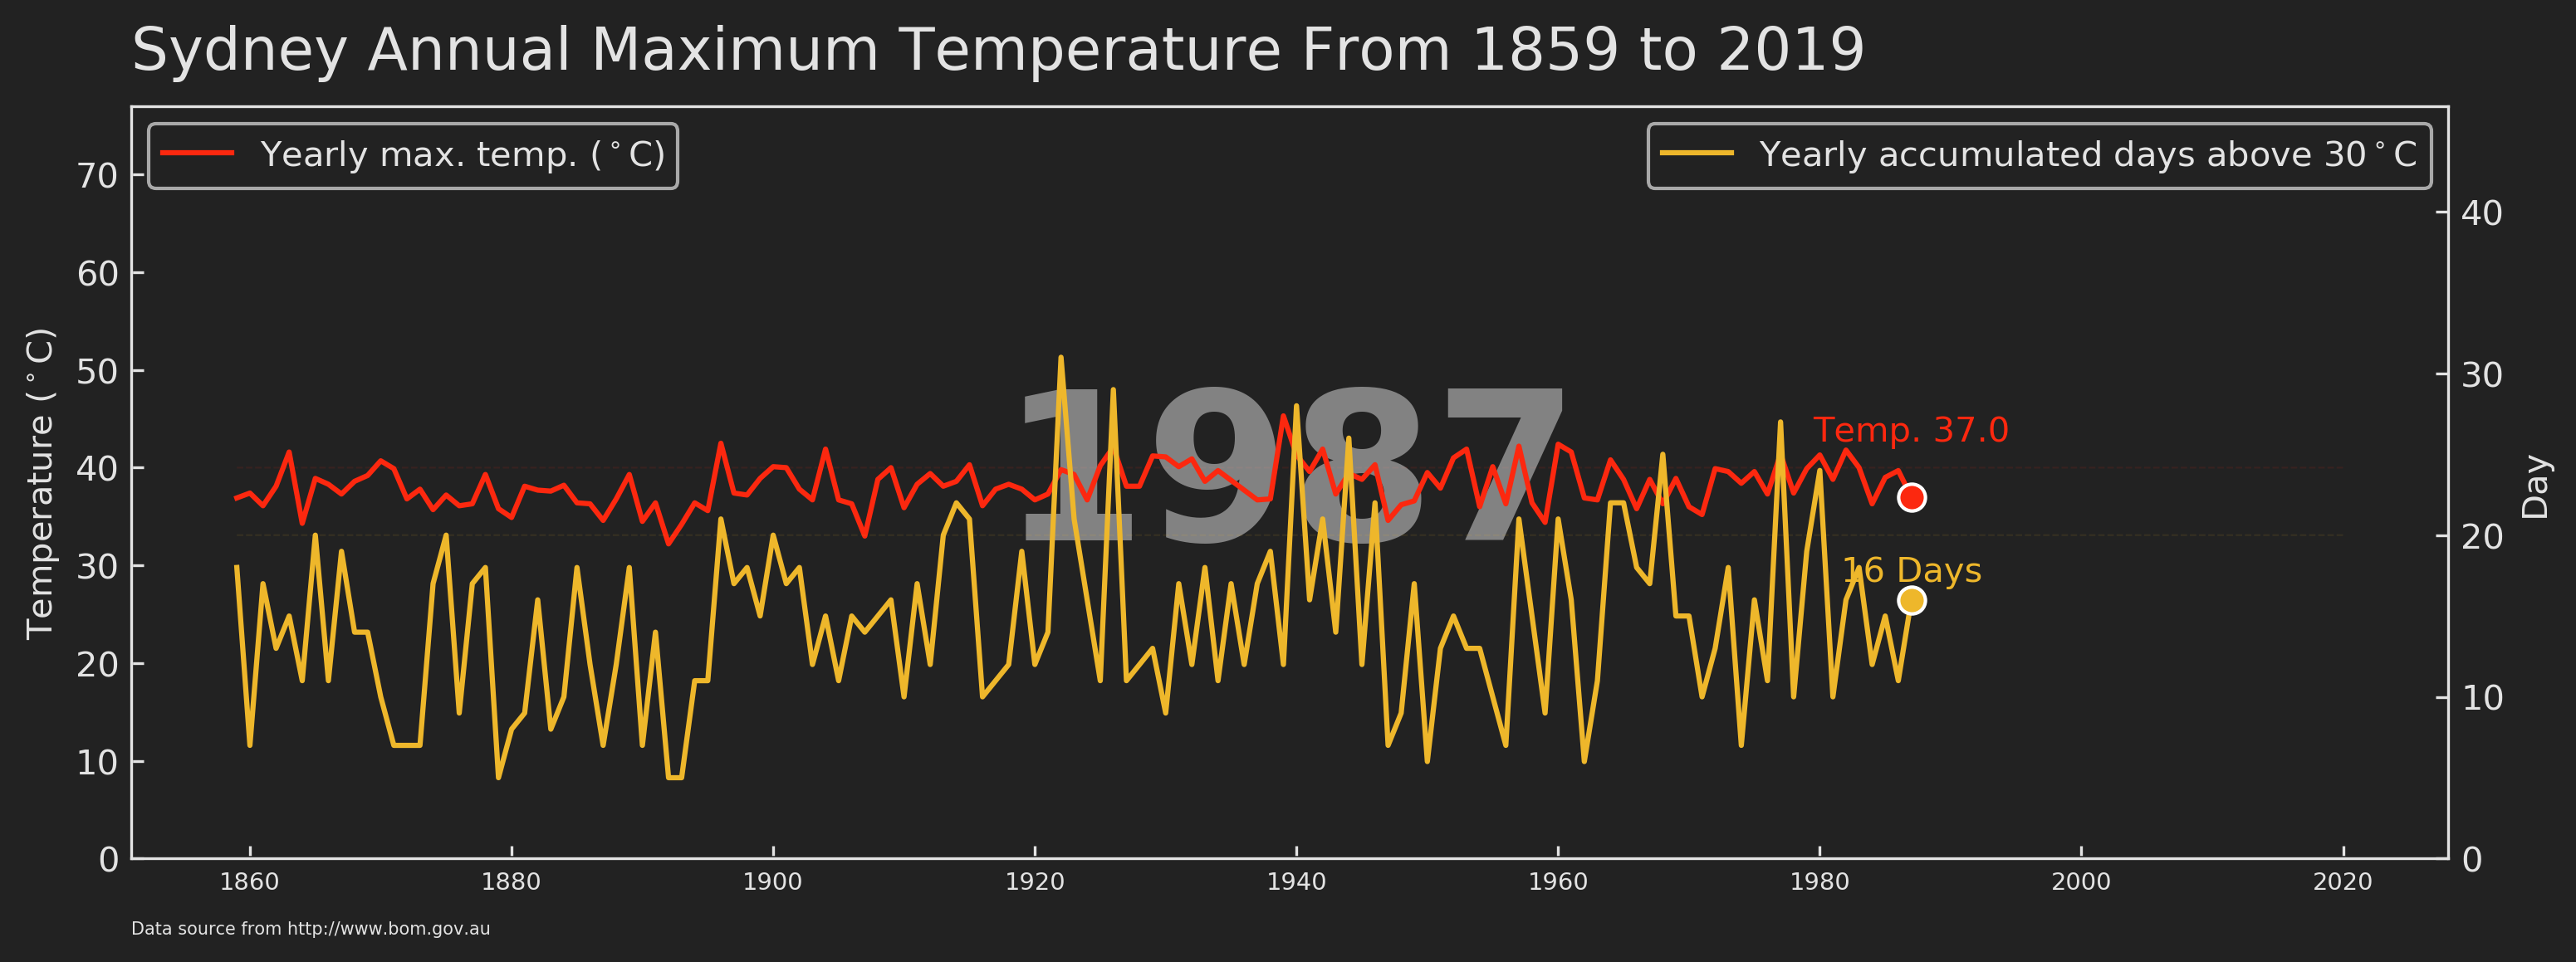

In [12]:
# run one frame to test the function
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
ax2 = ax.twinx()
draw_linechart(1987)

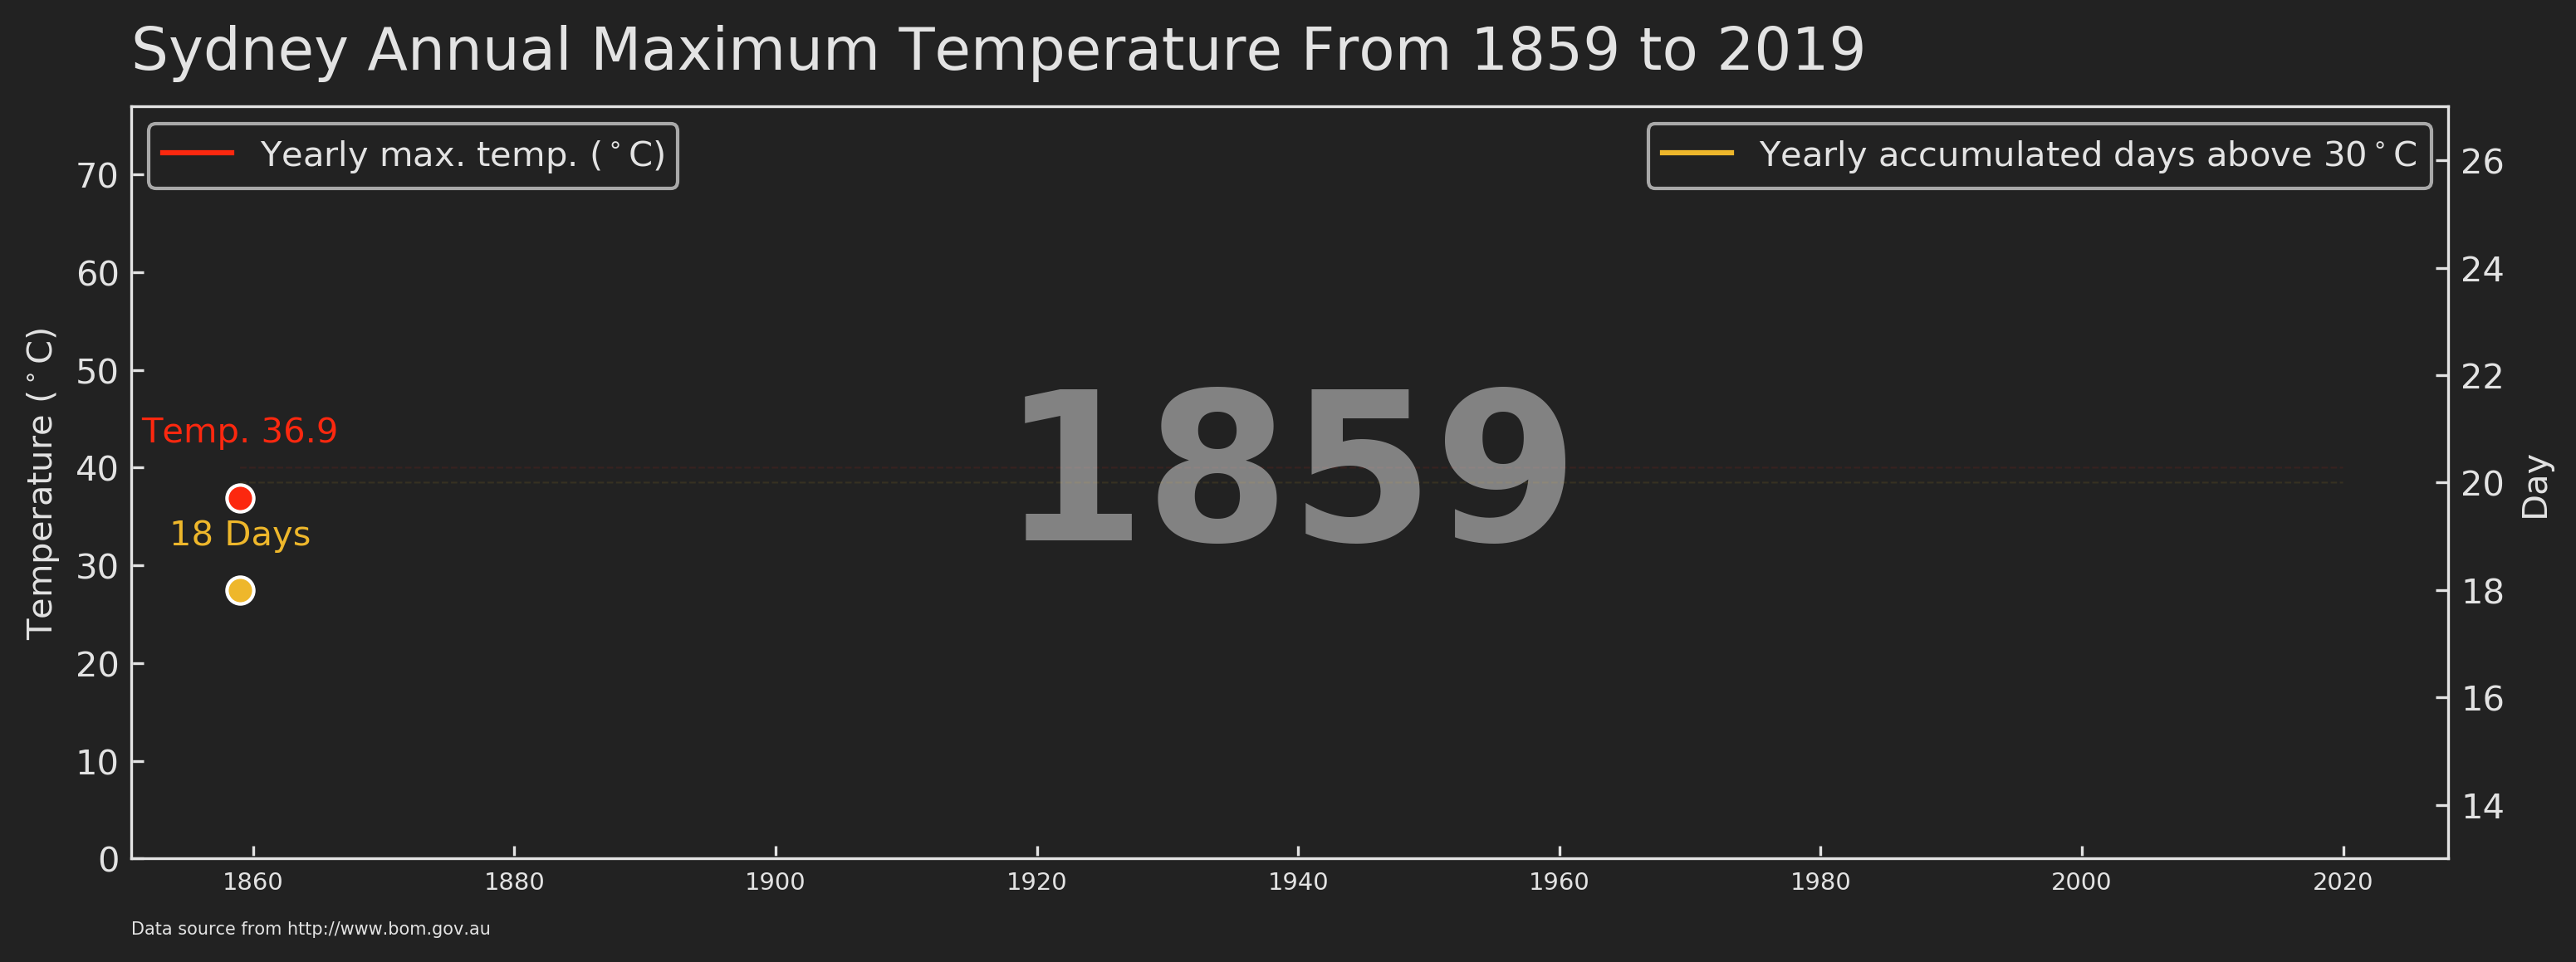

In [16]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
ax2 = ax.twinx()

animator = animation.FuncAnimation(fig, draw_linechart, 
                                   frames=np.arange(df_sydney.Year.values.min(),df_sydney.Year.values.max(),1), interval=300)

In [17]:
# you need install ffmpeg before running this code
animator.save('./animation4.mp4', savefig_kwargs={'facecolor':'#222222'}) # savefig_kwargs need to be specified to save figure background
# see https://github.com/matplotlib/matplotlib/issues/1008/

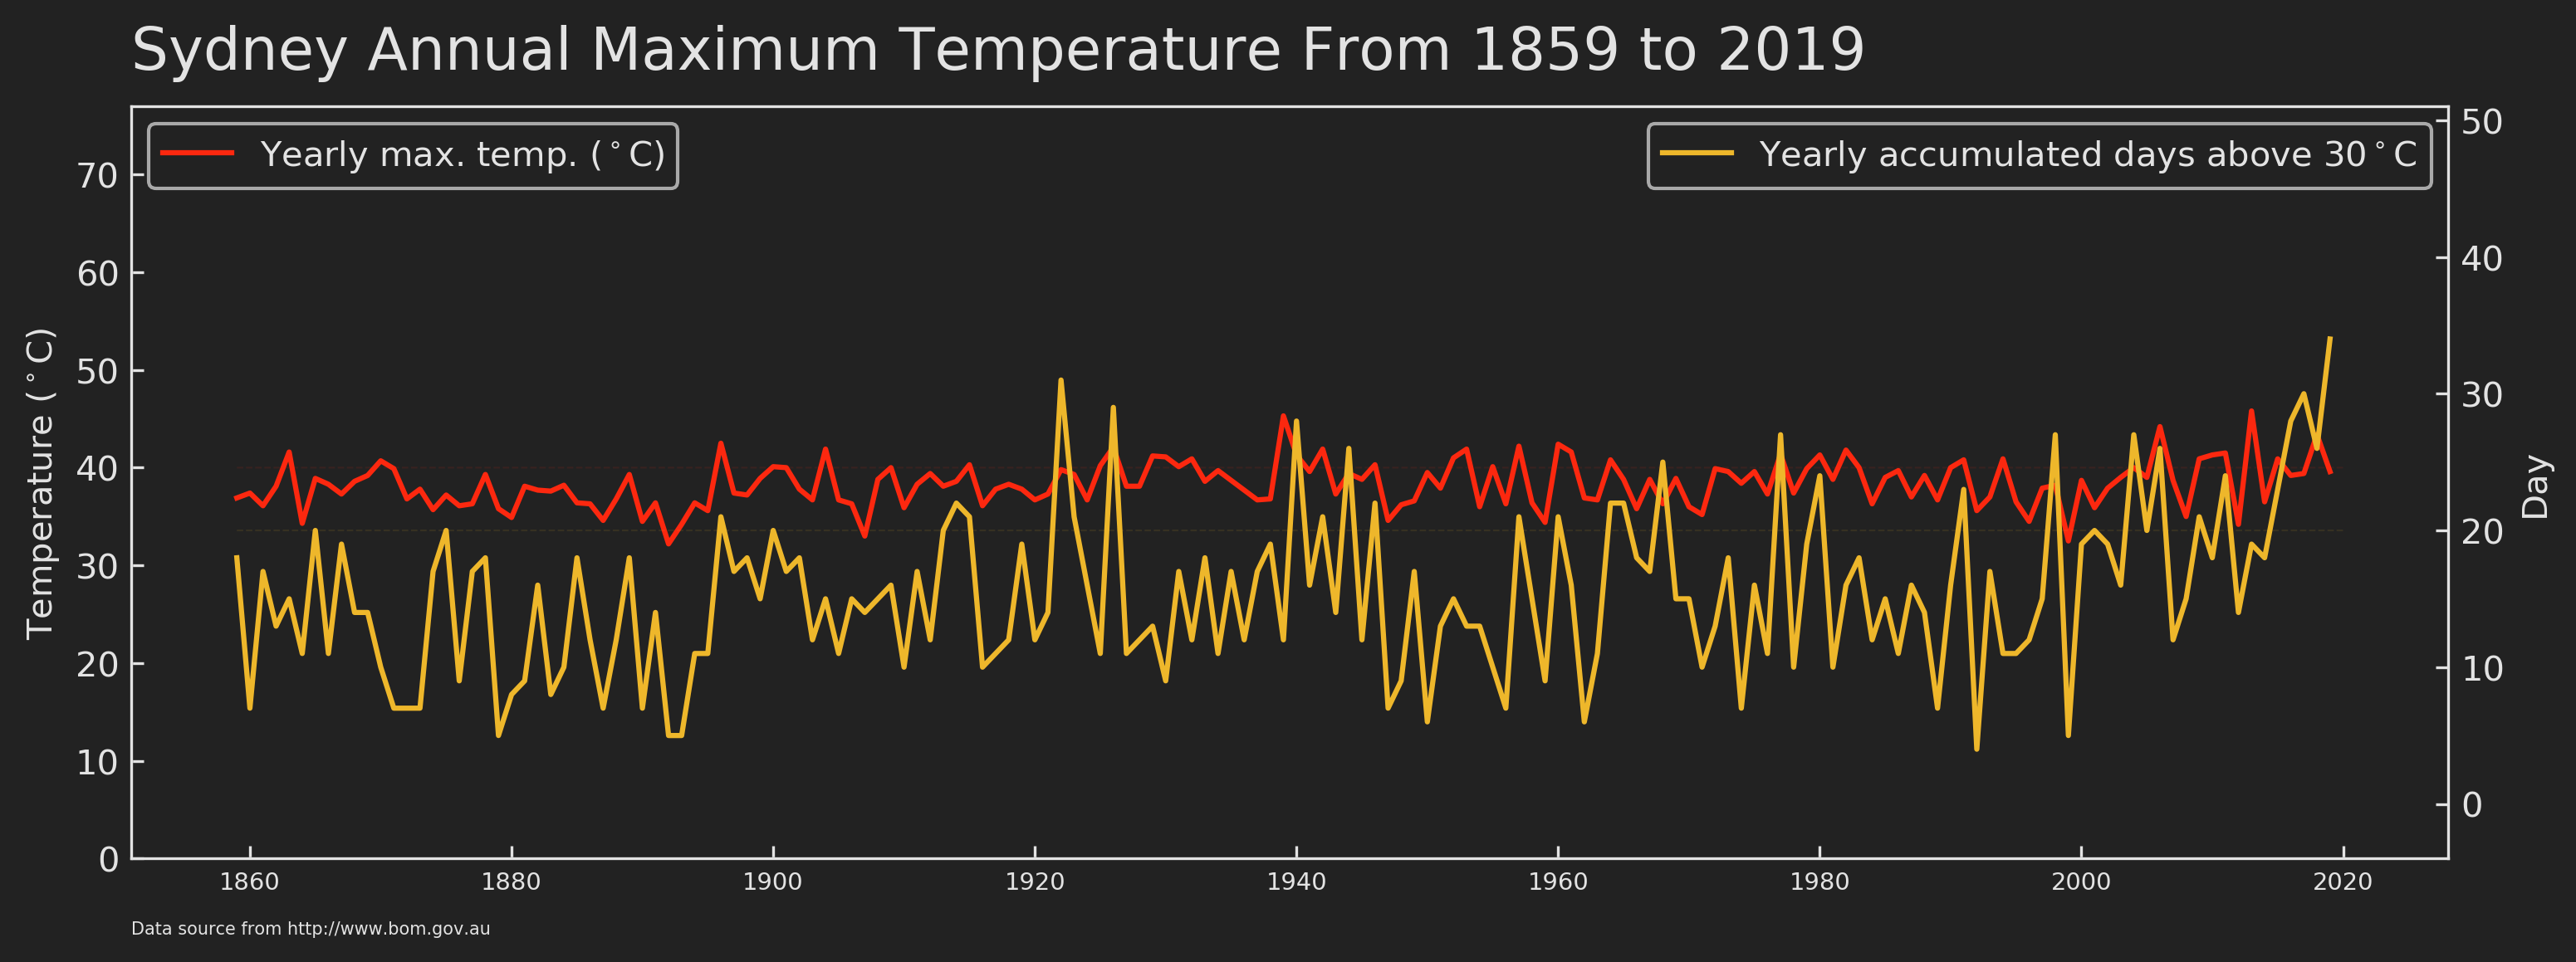

In [19]:
# code for static figure
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
ax2 = ax.twinx()
    
ax.clear()
ax2.clear()

# The horizontal line to indicate 40 degree, use the full data
ax.plot(df_sydney.Year, (df_sydney.max_tmp_year**0)*40, label='_1', 
        color='#fc280f', linestyle='dashed', alpha=0.1, linewidth=0.5, zorder=1)

# The horizontal line to indicate 20 days, use the full data
ax2.plot(df_sydney.Year, (df_sydney.hot_day**0)*20, label='_2', 
         color='#eeb72b', linestyle='dashed', alpha=0.1, linewidth=0.5, zorder=1)

# plot all data in one go. data for 2020 is not compeleted, so slicing data to not use it.
ax.plot(df_sydney.Year[0:58804], df_sydney.max_tmp_year[0:58804], label='Yearly max. temp. ($^\circ$C)', 
        color='#fc280f', zorder=2)
ax2.plot(df_sydney.Year[0:58804], df_sydney.hot_day[0:58804], label='Yearly accumulated days above 30$^\circ$C', 
             color='#eeb72b', zorder=2)

#ax.scatter(df_tmp.Year.values[-1], df_tmp.max_tmp_year.values[-1], color='w', s=100, edgecolor ='k', linewidth=1, zorder=3)
#ax2.scatter(df_tmp.Year.values[-1], df_tmp.hot_day.values[-1], color='w', s=100, edgecolor ='k', linewidth=1, zorder=3)

#ax.text(df_tmp.Year.values[-1], df_tmp.max_tmp_year.values[-1]+5,
#        s='Temp. {}'.format(df_tmp.max_tmp_year.values[-1]), size=10, 
#        color='#e3e3e3', ha='center', va='bottom', zorder=6)
#ax2.text(df_tmp.Year.values[-1], df_tmp.hot_day.values[-1], 
#        s='{} Days'.format(int(df_tmp.hot_day.values[-1])), size=10, 
#        color='#e3e3e3', ha='center', va='bottom', zorder=6)

#ax.text(0.5, 0.5, s=df_tmp.Year.values[-1], fontweight='bold', size=60, 
#        color='#e3e3e3', ha='center', va="center", 
#        alpha=0.5, transform=ax.transAxes, zorder=1)

l1 = ax.legend(loc='upper left')
    
for text in l1.get_texts():
    text.set_color('#e3e3e3')
        
l2 = ax2.legend(loc='upper right')
    
for text in l2.get_texts():
    text.set_color('#e3e3e3')
    
ax.set_ylim(0, df_sydney.max_tmp_year.max()*1.68)
ax.grid(b=None)
ax.set_ylabel('Temperature ($^\circ$C)', color='#e3e3e3')
    
ax2.grid(b=None) # Don't show grid of ax2 
ax2.set_ylim(df_sydney.hot_day.min()-5, df_sydney.hot_day.max()*1.5)
ax2.set_ylabel('Day', color='#e3e3e3')
ax2.spines['bottom'].set_color('#e3e3e3')  
ax2.spines['right'].set_color('#e3e3e3')  
ax2.spines['left'].set_color('#e3e3e3')  
ax2.spines['top'].set_color('#e3e3e3') 

    # Retrieve an element of a plot and set properties
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize('x-small')

ax.margins(x=0.05)

ax.text(0.00, 1.05, 'Sydney Annual Maximum Temperature From 1859 to 2019', color='#e3e3e3', 
        transform=ax.transAxes, size=17, weight='light', ha='left')
ax.text(0.00, -0.1, 'Data source from http://www.bom.gov.au', color='#e3e3e3', 
             transform=ax.transAxes, size=5, weight='light', ha='left')

fig.canvas.draw()

In [20]:
fig.savefig('static.png', facecolor='#222222')